# Image Clustering

This notebook uses the **[MobileNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet)** model to get a 1000 features for each image. 


In [ ]:
import random, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

## Chosen Dataset:

Scraped Image Data from the Instagram account: [@cats_of_brutalism](https://www.instagram.com/cats_of_brutalism/). This is a project advocating for brutalist architechture, directed by three MArch students from University of Buffalo. Their website reads: "Cats of Brutalism juxtaposes brutalist buildings with super-scaled cats as a means of introducing warmth, softness, and whimsy to the often-perceived-as cold, hard, and severe forms of brutalism."

The reason for choosing this dataset was to see if there are any common, recurring elements in brutalist buildings that could be clustered together in an organised way. The total number of images in this dataset is 432




## Load and resize images 

Loading in all the images and resize them to 224 x 224, as this is the resolution we need for inputting to MobileNet

In [ ]:
#Path to folder
path_to_images = "../images/cats_of_brutalism/"
#image extension
file_type = ".jpg"
#Pick image size
img_height = 224
img_width = 224
#Is it rgb or black and white?
channels = 1

In [ ]:
#Get all paths
paths = []
for root, dirs, files in os.walk(path_to_images, topdown=False):
    for name in files:
        if file_type in name.lower():
            paths.append(str(os.path.join(root, name)))
#Load in images
dataset = [np.array(img_to_array(load_img(i,target_size=((img_height,img_width)))))/255.0 for i in paths]
dataset = np.array(dataset).astype("float32")
dataset.shape

(432, 224, 224, 3)

## Loading pretrained model

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet
model = tensorflow.keras.applications.MobileNetV2(input_shape=(224,224,3), alpha=1.0, weights='imagenet', pooling=None)

## Getting Image Features

We end up with 1000 features for each image

In [ ]:
pred = model.predict(dataset)
print(pred.shape)
x = pred.reshape(dataset.shape[0], -1)

(432, 1000)


## Clustering 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Standardise 

Standardising the range of the dataset, as PCA and K-Means are effected by scale.

In [ ]:
x = StandardScaler().fit_transform(x)

## Plot in 2D

Using PCA to reduce the dataset to only 2 dimensions. 

In [ ]:
#Get reduced dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)

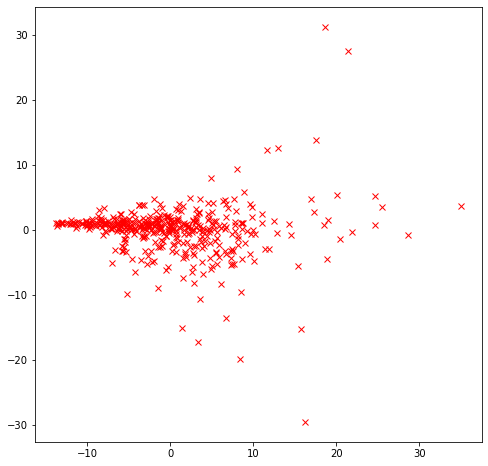

In [ ]:
#Plot
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"rx")

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

### Elbow Plot

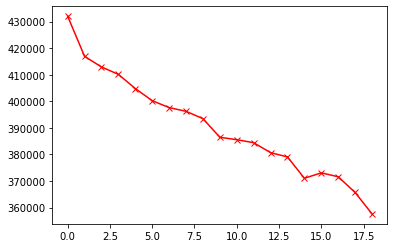

In [ ]:
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x)
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-rx")

A possible good value for k could be 8 as the range between 7.5 and 10.0 has quite a big jump.

## Cluster and Plot

Trying with all the features. 

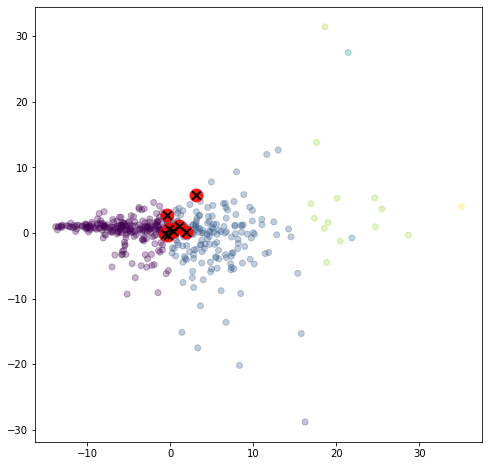

In [ ]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x)

The clusters and their centres are all populated together which makes it harder to understand what we're working with, hence we shall reduce it down to 2 dimensions for better results. 

## Reducing Dimensions before clustering

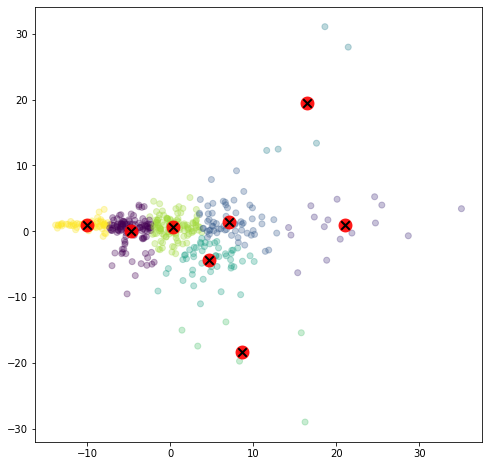

In [ ]:
num_dimensions = 2

# Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

# Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

# Plot results
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

The clusters right at the front are quite dense, whereas the clusters at the edges aren't.  

# Examine Clusters

Examine representative images of each cluster that are closest to the centre

In [ ]:
#Defining this custom function to display images in grid
from PIL import Image
from PIL import ImageDraw 
from PIL import ImageFont
font = ImageFont.truetype("../data/Arial.ttf", 24)
#Defining custom function to display images
def image_grid(imgs, rows, cols, labels = False):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    draw = ImageDraw.Draw(grid)
    for i, img in enumerate(imgs):
        r = i//cols
        c = i%cols
        pt = (c*w, r*h)
        color = (255,255,255)
        grid.paste(img, box=pt)
        if labels:
            label = "Cluster "+str(r) 
            draw.text(pt,label,color,font=font)
    return grid

### Number of Clusters

In [ ]:
#How many clusters?
k = 8

In [ ]:
#Getting image closest to the centre for each cluster
kmeans = KMeans(n_clusters=k, random_state=42)
#Dist to each cluster center for each image
x_dist = kmeans.fit_transform(x_less_dimensions)

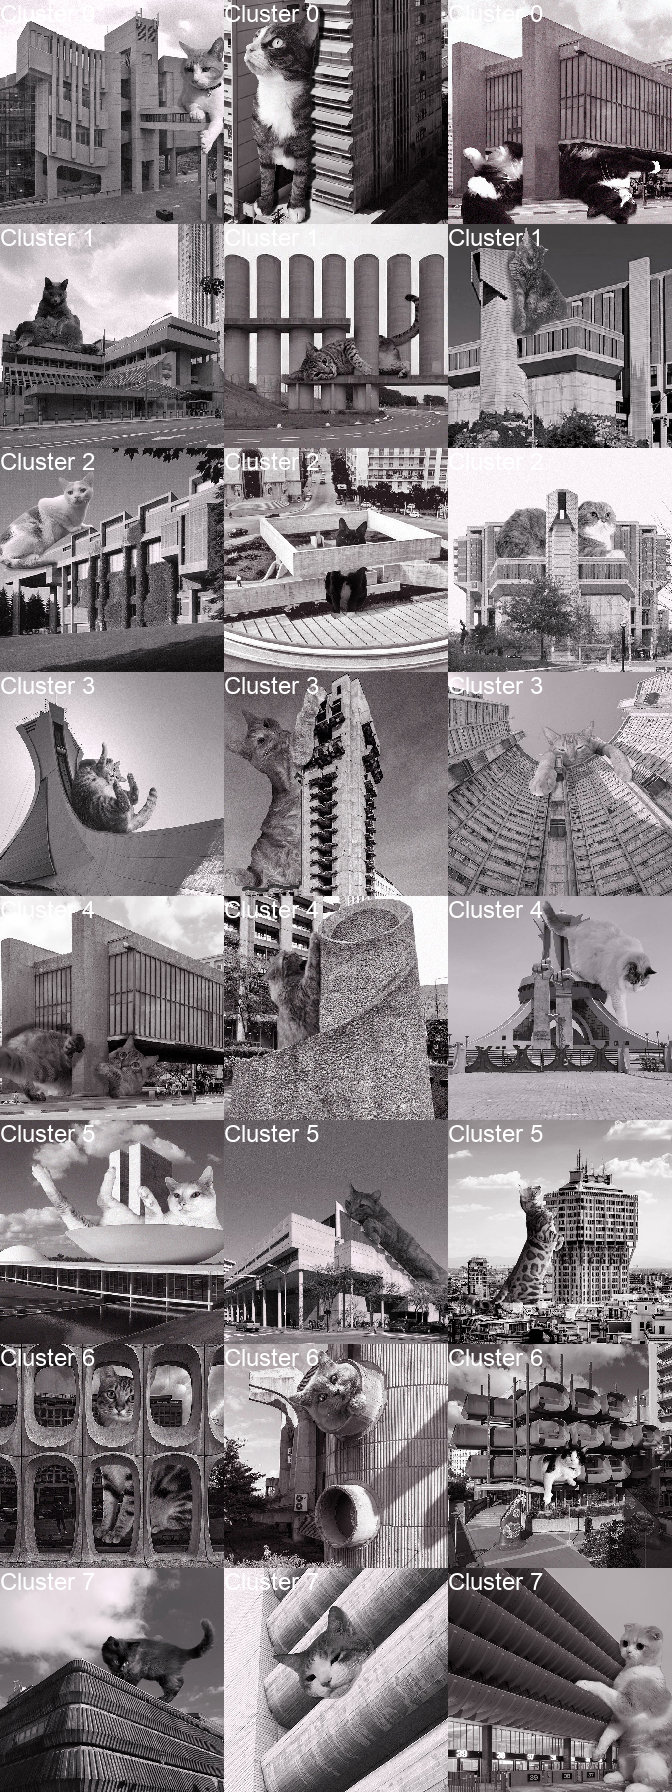

<Figure size 720x720 with 0 Axes>

In [ ]:
cols = 3
indexes = np.array([]).astype(int)
for i in range(k):
    #Getting distances for a given cluster (for all images)
    cluster_dist = x_dist[:,i]
    #Sorting ascending (shortest distance first) and taking nearest 3
    cluster_indexes = cluster_dist.argsort(axis = 0)[:cols]
    indexes = np.concatenate((indexes,cluster_indexes))
    
to_show = dataset[indexes]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

image_grid(to_show, k, cols, True)

### Examine most representative images for a given cluster

Here we can dive deeper and print out more images from a given cluster

In [ ]:
#What cluster to focus on?
cluster = 6
#How many images?
num_to_show = 9

Images Nearest the Centre of Cluster 6


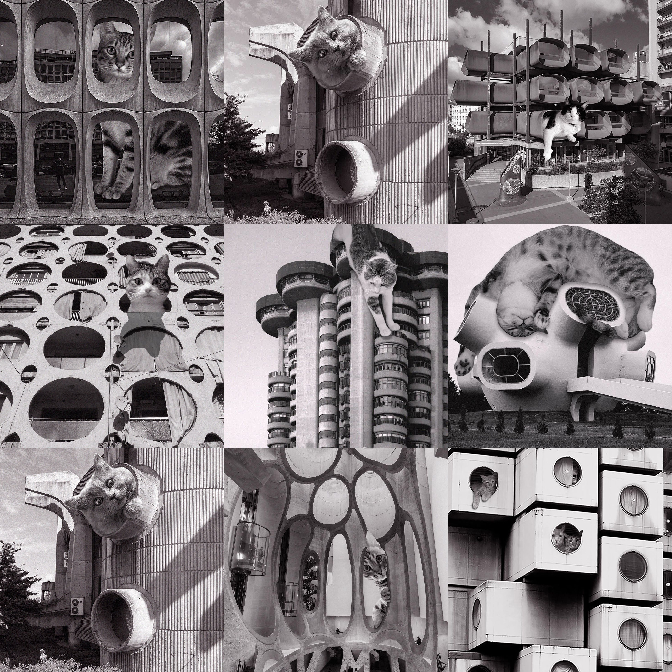

<Figure size 720x720 with 0 Axes>

In [ ]:
cluster_dist = x_dist[:,cluster]
#Sorting ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

# Image display
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 3, 3)

The images in Cluster 6 seem to be buildings and towers with a circular elements in common, most of them having cats peep out of them. This cluster has picked up a distinct brutalist architectural style, although there are some outliers present(possibly because the image dataset isn't that big). 

In [ ]:
#What cluster to focus on?
cluster = 5
#How many images?
num_to_show = 9

Images Nearest the Centre of Cluster 5


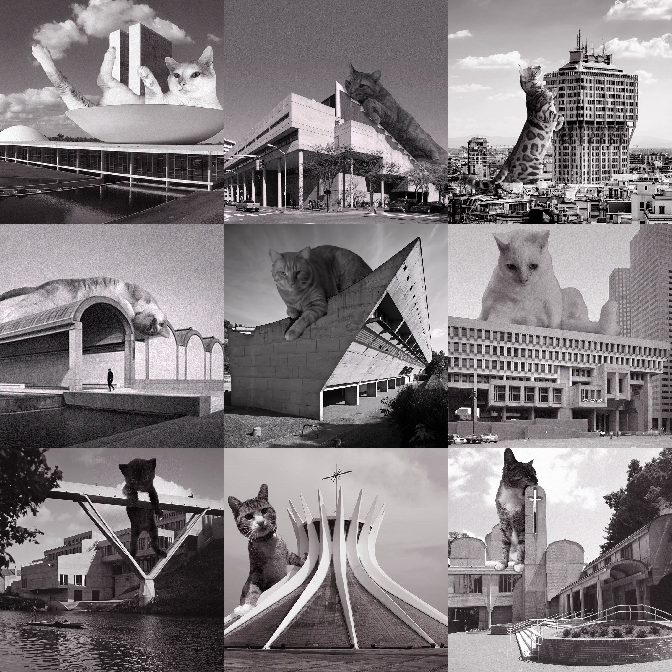

<Figure size 720x720 with 0 Axes>

In [ ]:
cluster_dist = x_dist[:,cluster]
#Sorting ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

# Image display
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 3, 3)

Even Cluster 5 has some really nice pictures of cats lazing around / trying to climb up these buildings which seesm to be the common element. 

## Changing K Value:

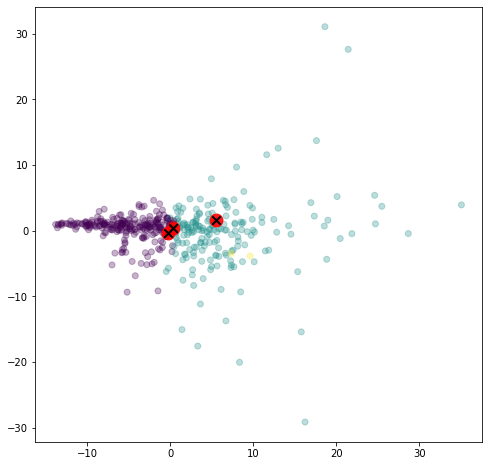

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x)

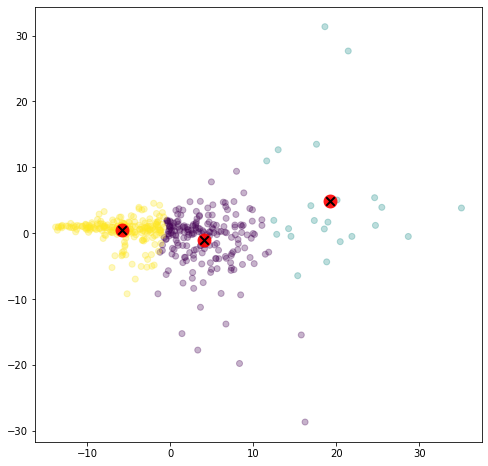

In [ ]:
num_dimensions = 2

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

In [ ]:
#What cluster to focus on?
cluster = 2
#How many images?
num_to_show = 9

Images Nearest the Centre of Cluster 2


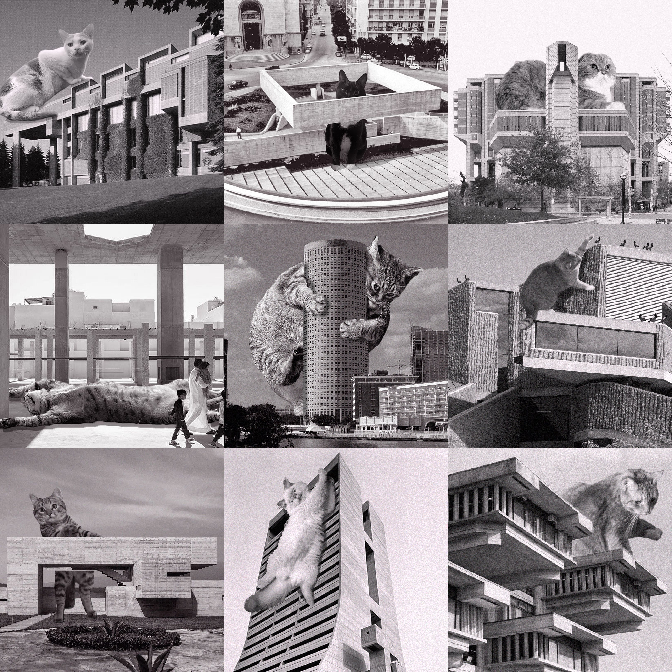

<Figure size 720x720 with 0 Axes>

In [ ]:
cluster_dist = x_dist[:,cluster]
#Sorting ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

# Image display
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 3, 3)

After having changed the K value from 8 to 3, it seems like it's somehow harder to find a common element unifying all the 6 images (despite them being the most representative). This could possibly be because having more clusters could make it harder for outliers to be present as the division would be more specific (as seen with 8 clusters). Although, quite a few clusters when the K value was 8 did have a couple of outliers too. A good reason for this could be that this dataset has two elements that are constantly recurring in every image: cats and brutalism. Since the subject  present in the frame is what allows the clustering (as opposed to colour or art style), this might be a slightly complicated task using this technique. It did however manage to have some clusters with very distinct building styles which was good.  